# Phishing Detection Capstone Project

This notebook implements a phishing detection system using XGBoost, with features extracted from URLs, source code, and webpage screenshots. The project includes:

- Data preprocessing and feature extraction (from `feature_extract.py`)
- Handling imbalanced data with SMOTEENN
- Training and tuning Logistic Regression and XGBoost models
- Evaluating performance on balanced and imbalanced test sets
- Visualizing results with confusion matrices, precision-recall curves, ROC curves, and feature importance
- Measuring inference time for real-time applicability

In [2]:
# Imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time

In [3]:
# Load and preprocess data
df = pd.read_csv('features.csv')
X = df.drop(['label'], axis=1)
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Train Logistic Regression with class weights
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [5]:
# Train XGBoost with scale_pos_weight
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # Negative/Positive ratio
xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_xgb = grid_search.best_estimator_
print(f"Best XGBoost Params: {grid_search.best_params_}")

Best XGBoost Params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}


In [6]:
# Evaluate on balanced test set
lr_preds = lr_model.predict(X_test_scaled)
xgb_preds = best_xgb.predict(X_test_scaled)
print("Logistic Regression Performance (Balanced Test Set):")
print(classification_report(y_test, lr_preds))
print("XGBoost Performance (Balanced Test Set):")
print(classification_report(y_test, xgb_preds))

Logistic Regression Performance (Balanced Test Set):
              precision    recall  f1-score   support

           0       0.57      0.77      0.65      1739
           1       0.95      0.88      0.91      8482

    accuracy                           0.86     10221
   macro avg       0.76      0.83      0.78     10221
weighted avg       0.88      0.86      0.87     10221

XGBoost Performance (Balanced Test Set):
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1739
           1       0.97      0.94      0.95      8482

    accuracy                           0.93     10221
   macro avg       0.86      0.90      0.88     10221
weighted avg       0.93      0.93      0.93     10221



In [7]:
# Create an imbalanced test set (10% phishing, 90% benign)
phishing_test = df[df['label'] == 1].sample(frac=0.1, random_state=42)
benign_test = df[df['label'] == 0].sample(frac=0.9, random_state=42)
imbalanced_test = pd.concat([phishing_test, benign_test])
X_imbalanced = imbalanced_test.drop(['label'], axis=1)
y_imbalanced = imbalanced_test['label']
X_imbalanced_scaled = scaler.transform(X_imbalanced)

# Evaluate on imbalanced test set
lr_preds_imbalanced = lr_model.predict(X_imbalanced_scaled)
xgb_preds_imbalanced = best_xgb.predict(X_imbalanced_scaled)
print("Logistic Regression Performance (Imbalanced Test Set):")
print(classification_report(y_imbalanced, lr_preds_imbalanced))
print("XGBoost Performance (Imbalanced Test Set):")
print(classification_report(y_imbalanced, xgb_preds_imbalanced))

Logistic Regression Performance (Imbalanced Test Set):
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      7827
           1       0.67      0.87      0.76      4241

    accuracy                           0.80     12068
   macro avg       0.79      0.82      0.80     12068
weighted avg       0.83      0.80      0.81     12068

XGBoost Performance (Imbalanced Test Set):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7827
           1       0.94      0.96      0.95      4241

    accuracy                           0.96     12068
   macro avg       0.96      0.96      0.96     12068
weighted avg       0.97      0.96      0.96     12068



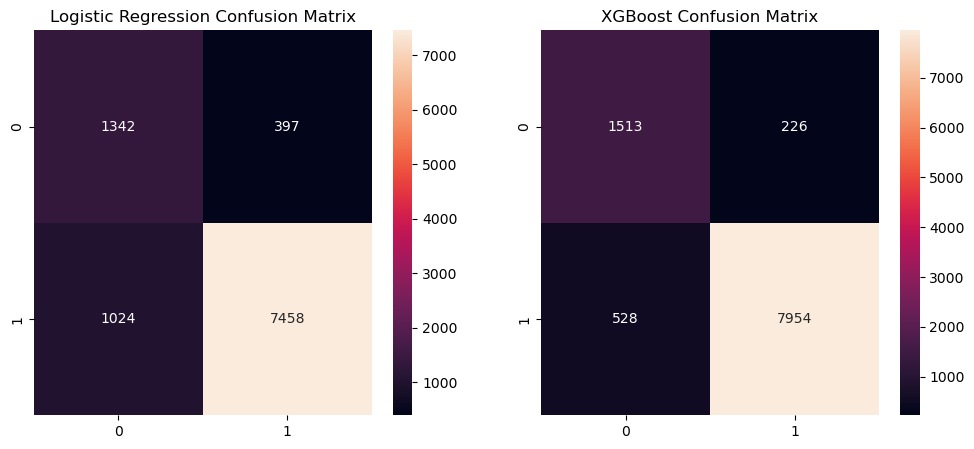

In [8]:
# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d', ax=ax1)
ax1.set_title('Logistic Regression Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', ax=ax2)
ax2.set_title('XGBoost Confusion Matrix')
plt.show()

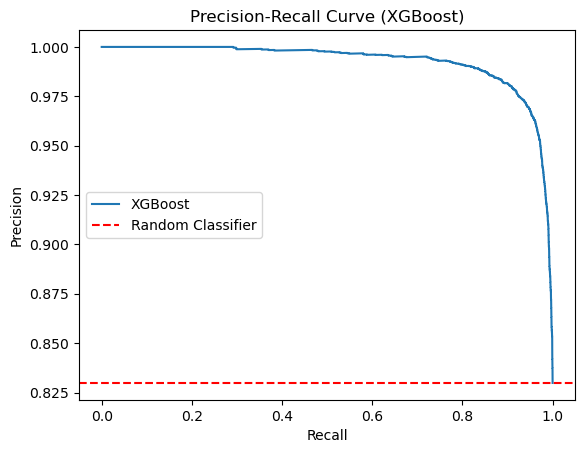

In [9]:
# Precision-Recall Curve with baseline
xgb_probs = best_xgb.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
plt.plot(recall, precision, label='XGBoost')
plt.axhline(y=sum(y_test) / len(y_test), color='r', linestyle='--', label='Random Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.show()

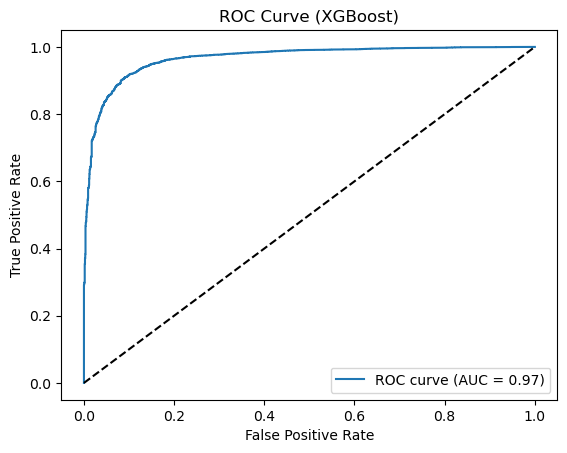

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend()
plt.show()

Feature Importance:
                   feature  importance
6      num_external_links    0.264249
5  has_suspicious_keyword    0.156361
2               has_https    0.137239
4       num_special_chars    0.130225
1          num_subdomains    0.090024
7             num_scripts    0.078772
0              url_length    0.072164
3             num_hyphens    0.070966


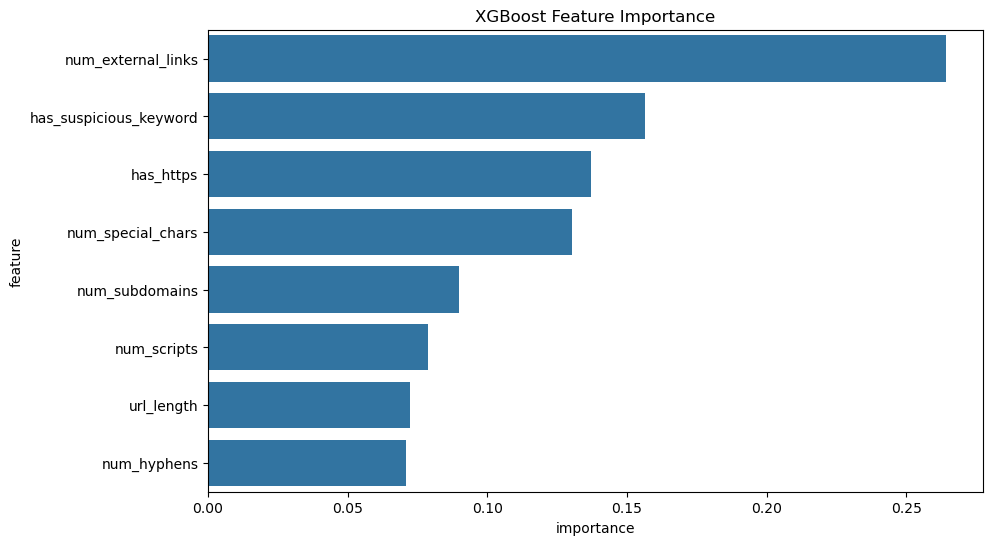

In [11]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)
print("Feature Importance:\n", feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.show()

In [12]:
# Automated threshold tuning
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Adjust predictions with optimal threshold
xgb_preds_adjusted = (xgb_probs >= optimal_threshold).astype(int)
print("XGBoost Performance (Adjusted Threshold):")
print(classification_report(y_test, xgb_preds_adjusted))

Optimal Threshold: 0.21328768134117126
XGBoost Performance (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1739
           1       0.95      0.97      0.96      8482

    accuracy                           0.94     10221
   macro avg       0.90      0.87      0.88     10221
weighted avg       0.94      0.94      0.94     10221



In [13]:
# Measure end-to-end inference time
start_pipeline = time.time()
xgb_preds = best_xgb.predict(X_test_scaled)
end_pipeline = time.time()
print(f"End-to-End Inference Time: {(end_pipeline - start_pipeline) * 1000:.2f} ms")

End-to-End Inference Time: 6.12 ms
